In [1]:
from torch.utils.data import DataLoader
import torchvision
import matplotlib.pyplot as plt
import numpy as np

import train

Files already downloaded and verified


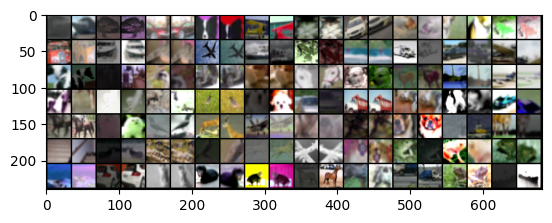

In [7]:
transforms = train.simCLR_transform()

cifarTest = train.CIFAR10_Paired(
    root="./data", train=False, download=True, transform=transforms
)
testLoader = DataLoader(cifarTest, batch_size=70, shuffle=True)

images, labels = next(iter(testLoader))
shape = images.shape
images = images.view(shape[0] * 2, shape[2], shape[3], shape[4])

grid = torchvision.utils.make_grid(images, nrow=20)
grid = np.transpose(grid, (1, 2, 0))

_ = plt.imshow(grid)